In [1]:
from tp.util import Mapa, simulador, SimuladorFactory
from tp.presentacion import plot_satisfacciones_para_alpha, smooth_data
import tp.util.json as json
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
plt.style.use('ggplot')

In [2]:
cuatro_cuadrantes = Mapa.load('./tp/data/mapas/cuatro_cuadrantes.txt', barrios_definidos='./tp/data/mapas/barrios.json')

habitantes_por_barrio = [
    (cuatro_cuadrantes.mapa == i).sum()
    for i in range(4)
]

In [3]:
resultados_list = glob('./tp/data/resultados/cuatro_cuadrantes_1.0_9631_100/*.json')

In [15]:
resultados_list

[]

In [4]:
def extraer_mediciones_totales(resultados: dict, key: str):
    mediciones = dict()
    for r in resultados:
        alpha = r['alpha']
        rango = r['rango']

        mediciones.setdefault(alpha, {}).setdefault(rango, r[key])
    
    return mediciones

def extraer_mediciones_por_barrio(resultados: dict, key: str):
    mediciones = dict()
    for r in resultados:
        alpha = r['alpha']
        rango = r['rango']

        for s in r[key]:
            mediciones.setdefault(alpha, {}).setdefault(rango, []).append(s)
    
    return mediciones


In [5]:
start_max_1 = [x for x in resultados_list if x.rsplit('_', 4)[1] == '1.0']
start_max_10 = [x for x in resultados_list if x.rsplit('_', 4)[1] == '10.0']

In [6]:
def nested_dict_to_tidy_df(nested_dict):
    data = []
    for seed, sub_dict1 in nested_dict.items():
        for alpha, sub_dict2 in sub_dict1.items():
            for rango, value_list in sub_dict2.items():
                for barrio, satisfechos in enumerate(value_list):
                    data.append({'seed': seed, 'alpha': alpha, 'rango': rango, 'barrio': barrio, 'valor': satisfechos})
    
    df = pd.DataFrame(data)
    return df

In [7]:
mediciones_t = dict()
medicion = 'ginis_u'

for filename in start_max_10:
    resultados = json.load(filename)
    mediciones = extraer_mediciones_por_barrio(resultados, medicion)
    seed = filename.rsplit('_',1)[-1].rsplit('.')[0]
    mediciones_t[seed] = mediciones

In [8]:
df = nested_dict_to_tidy_df(mediciones_t)
df.to_csv(f'./{medicion}_cuatro_cuadrantes_10.0.csv', index=False)

In [13]:
df = pd.read_csv(f'./satisfechos_cuatro_cuadrantes_1.0.csv')

FileNotFoundError: [Errno 2] No such file or directory: './satisfechos_cuatro_cuadrantes_1.0.csv'

In [14]:
import numpy as np
from tp.presentacion import smooth_data
from matplotlib.ticker import FuncFormatter

In [12]:
df

""


In [11]:
color_dict = {
    0:"#E15759",
    1:"#4E79A7",
    2:"#59A14F",
    3:"#F28E2B"
}

def smoothstep(x):
    return 3*x**2 - 2*x**3

data_b = [list() for _ in range(4)]

alpha_i = 2 # cambiar esto para distintos alphas
ALPHA = df.alpha.unique()[alpha_i]

fig = plt.figure(figsize=(10,6))
for barrio in range(4):
    for i,seed in enumerate(df.seed.unique()):
        data = df[(df.barrio == barrio) & (df.alpha == ALPHA) & (df.seed == seed)]
        y =  data.valor
        # y *= 100
        # y /= habitantes_por_barrio[barrio]
        #plt.ylim(0,100)
        data_b[barrio].append(np.array(y))
        smooth_y = smooth_data(y, window_length= len(y) // int(2*len(str(len(y)))))
        x = np.linspace(0, 1, len(smooth_y))

        plt.xlim(0,1)
        opacity = min(1, .3 + smoothstep(1 / (i+1))) * .85
        plt.plot(x,smooth_y, color=color_dict[barrio], alpha=opacity)
        #plt.plot(x,y, color=color_dict[barrio], alpha=0.5)


for barrio in range(4): plt.plot([], label=f'Barrio {barrio}', color=color_dict[barrio])
legend = plt.legend(loc='best')
for text in legend.get_texts():
    text.set_color('black')
plt.show();

fig = plt.figure(figsize=(10,10))
fig.suptitle(f'Barrio {barrio}')
axs = fig.subplots(4,1)
fig.subplots_adjust(hspace=0.5)
suptitle = fig.suptitle(f'Máximas diferencias relativas \n entre los valores medidos en cada rango de visión')
suptitle.set_fontsize(16)
suptitle.set_color('black')
for barrio in range(4):
    data_b_i = data_b[barrio]
    data_b_i = pd.DataFrame(data_b_i)

    diffs = {}
    for c in data_b_i.columns:
        mx = data_b_i[c].max()
        mn = data_b_i[c].min()

        # dif. absoluta
        # diffs[c] = mx - mn

        # dif relativa (%)
        diffs[c] = 100 * (mx - mn) / mx

        # st. dev.
        # diffs[c] = data_b_i[c].std()

    differences = list(diffs.values())
    # smooth_diffs = smooth_data(differences, window_length= len(differences) // (4*len(str(len(differences)))) )
    # axs[barrio].plot(smooth_diffs, color=color_dict[barrio], alpha=1)
    
    axs[barrio].set_xlim(0, 1)
    axs[barrio].set_ylim(0, 100)
    title = axs[barrio].set_title(f'Barrio {barrio}', loc='left')
    title.set_fontsize(14)
    title.set_color('black')

    axs[barrio].set_ylabel('Diferencia relativa (%)')
    axs[barrio].set_xlabel('Rango de visión (%)')

    axs[barrio].plot(np.linspace(0,1,len(differences)), differences, color=color_dict[barrio], alpha=1)
    axs[barrio].xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x * 100)}%'))
    axs[barrio].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}%'))

plt.show();

AttributeError: 'DataFrame' object has no attribute 'alpha'

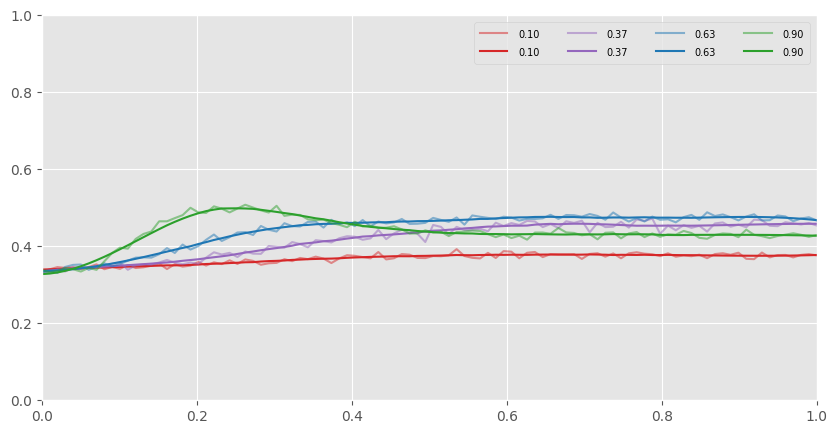

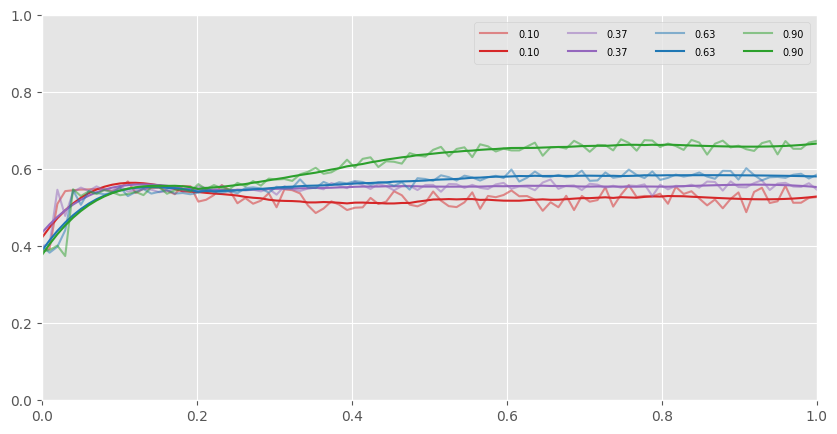

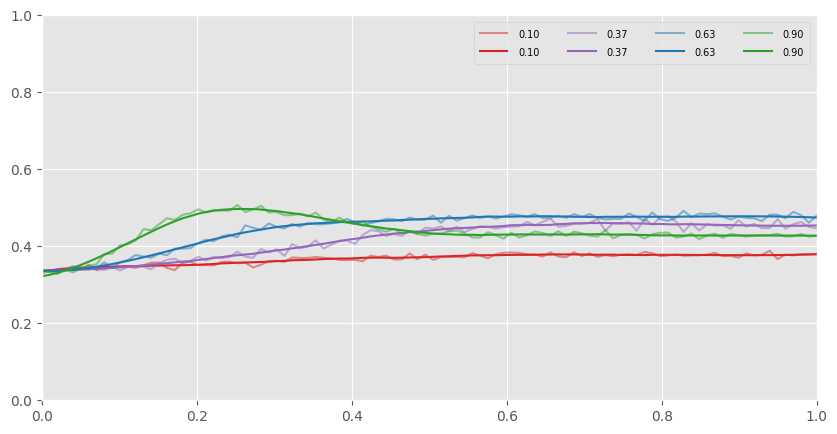

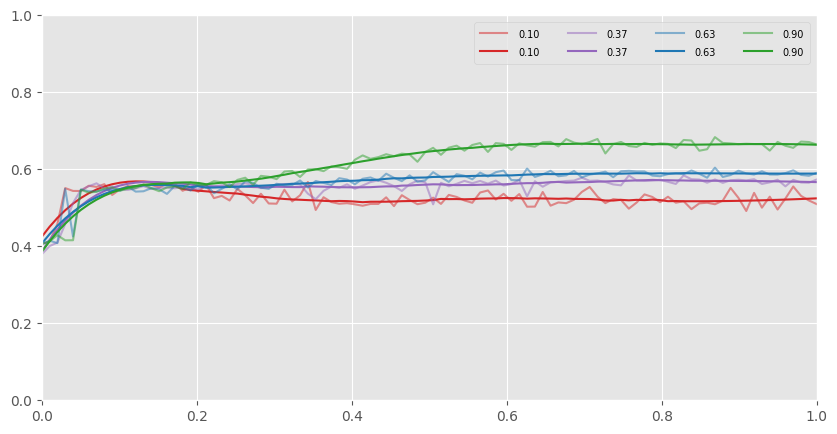

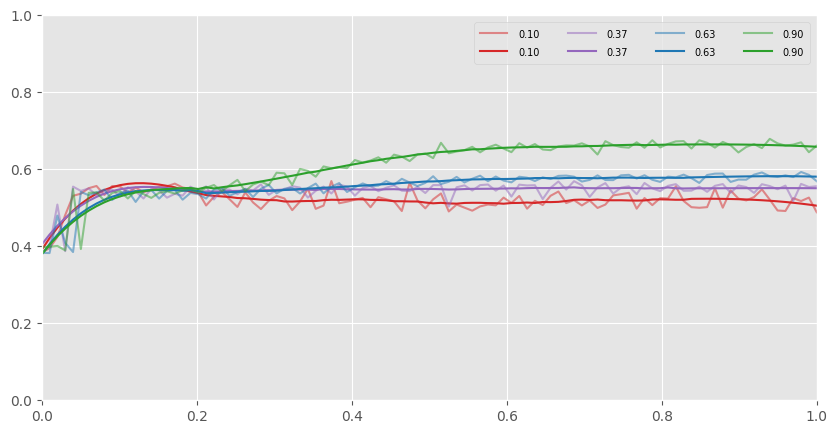

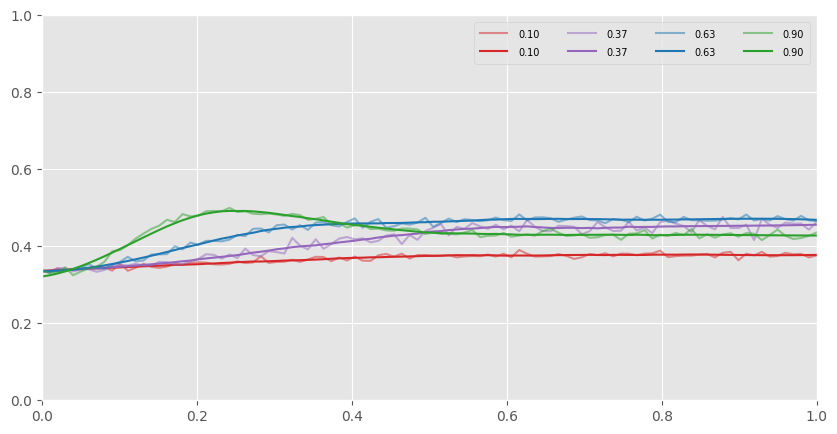

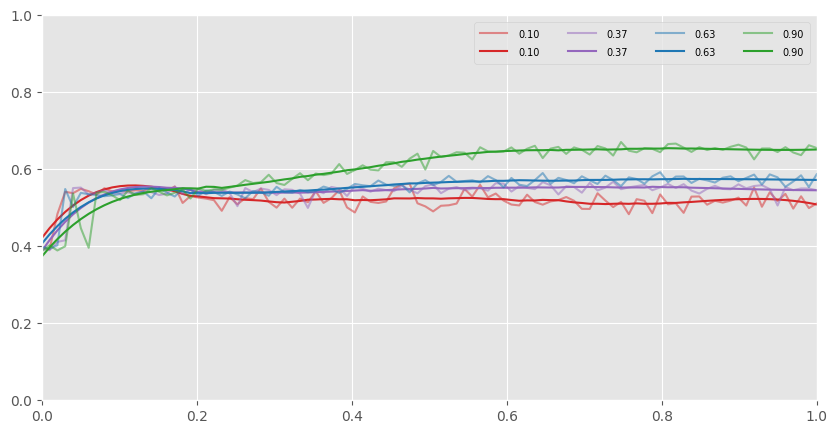

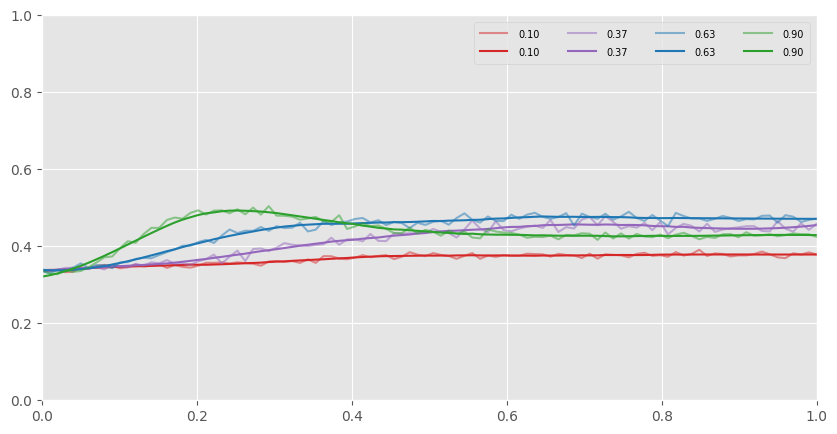

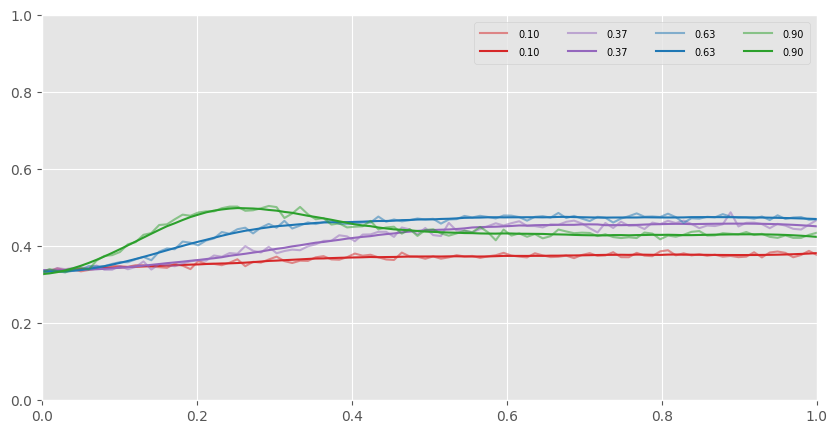

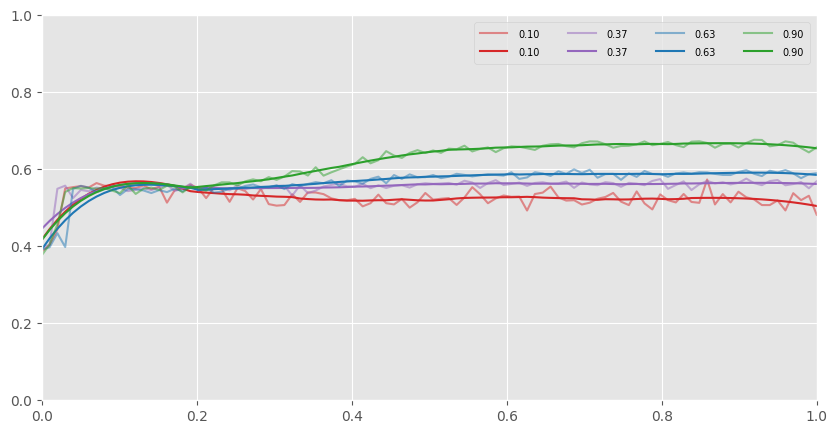

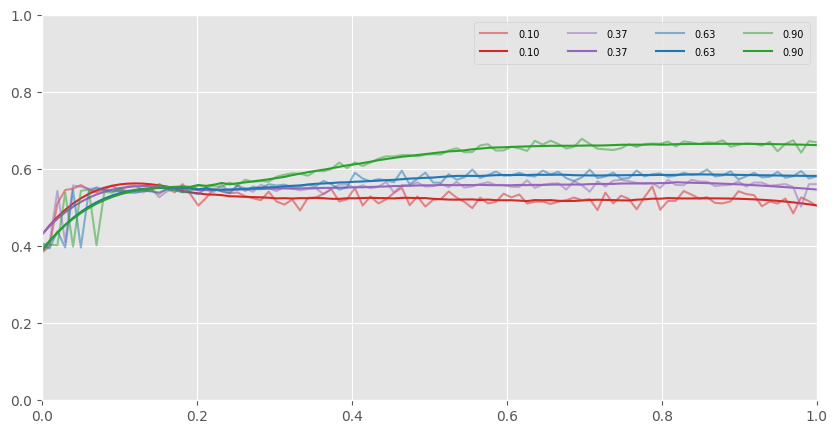

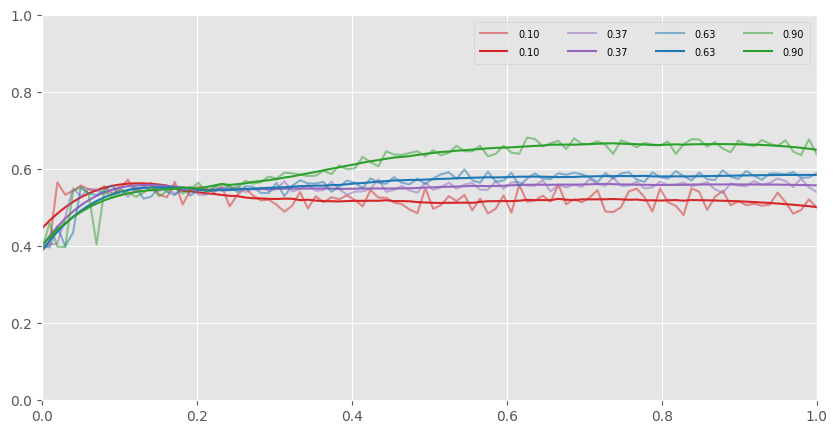

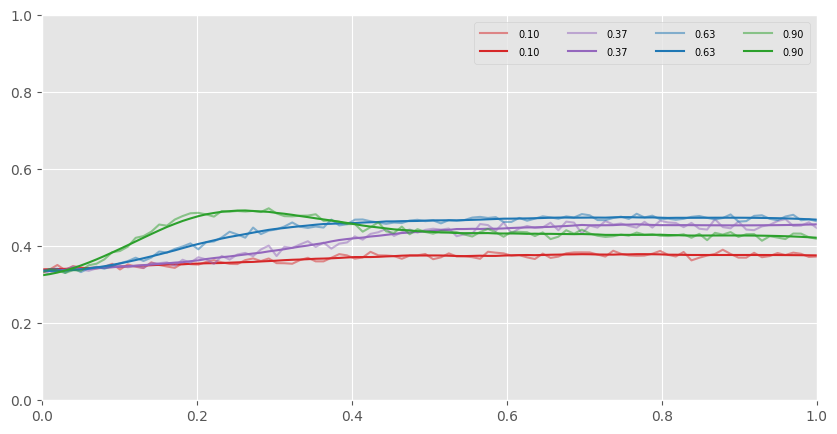

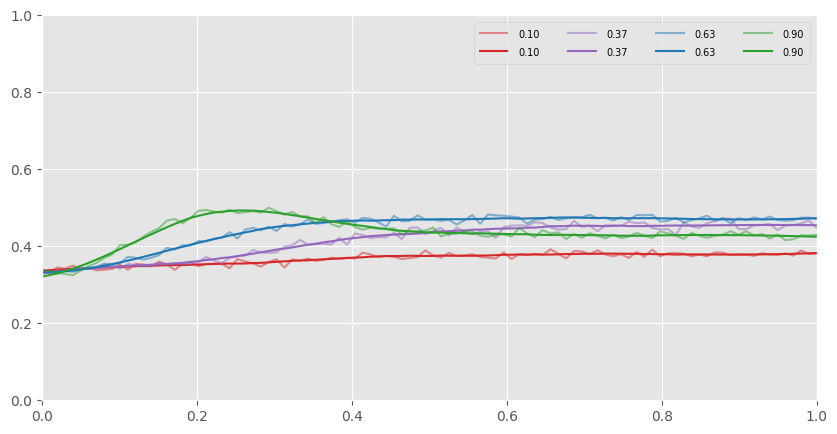

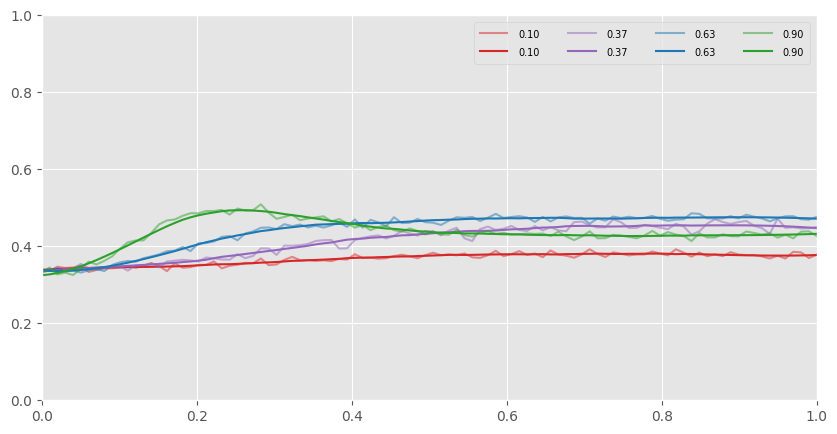

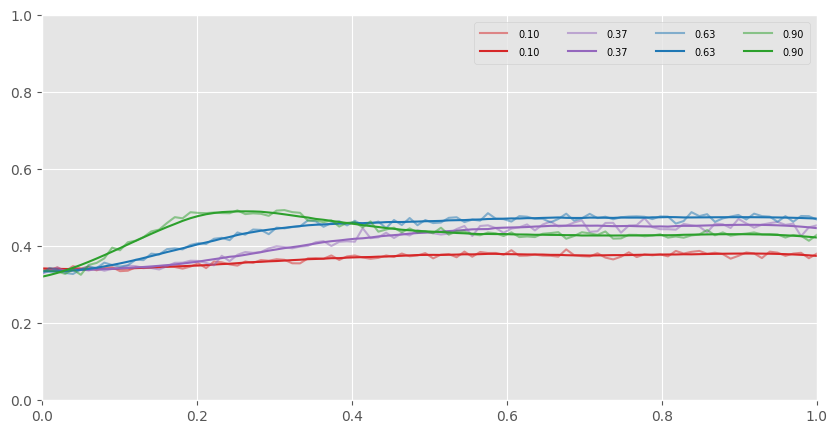

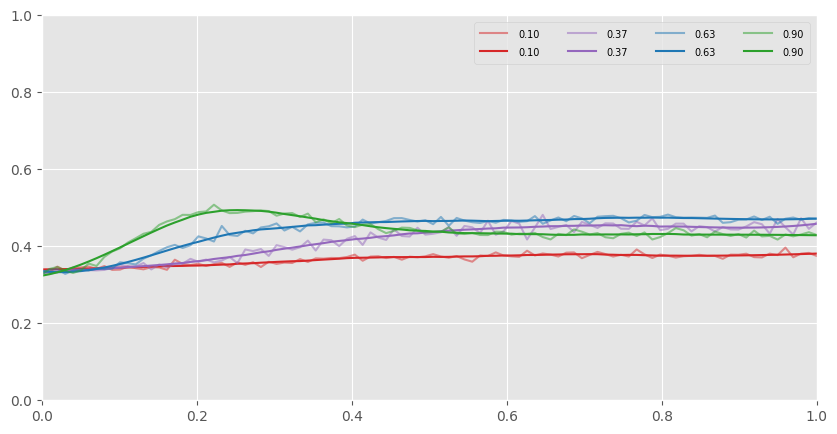

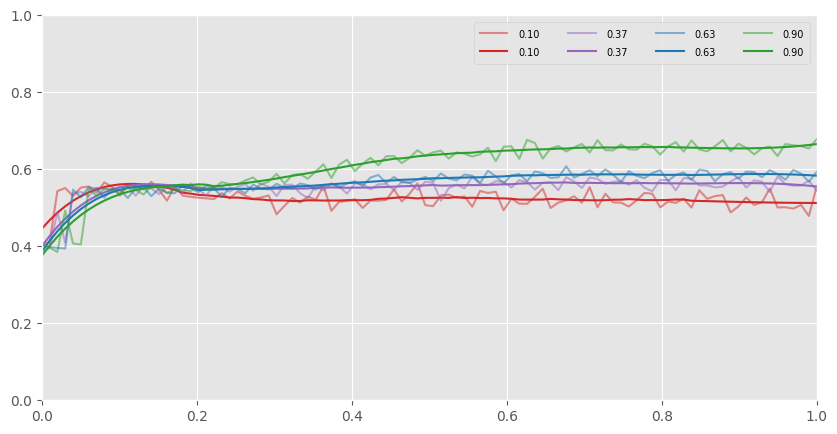

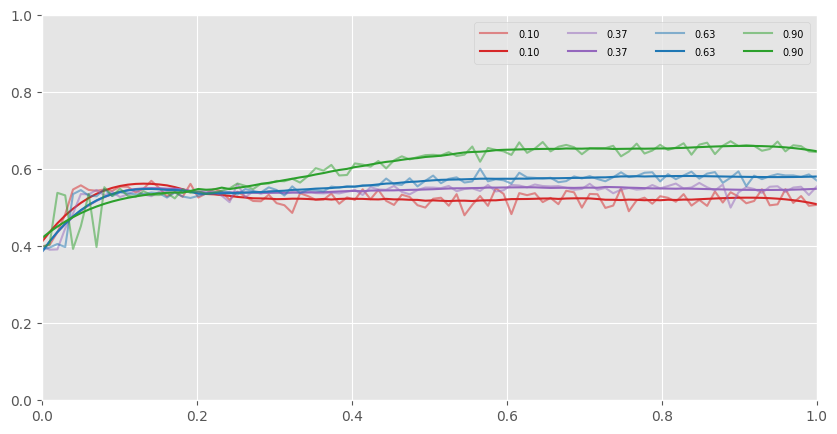

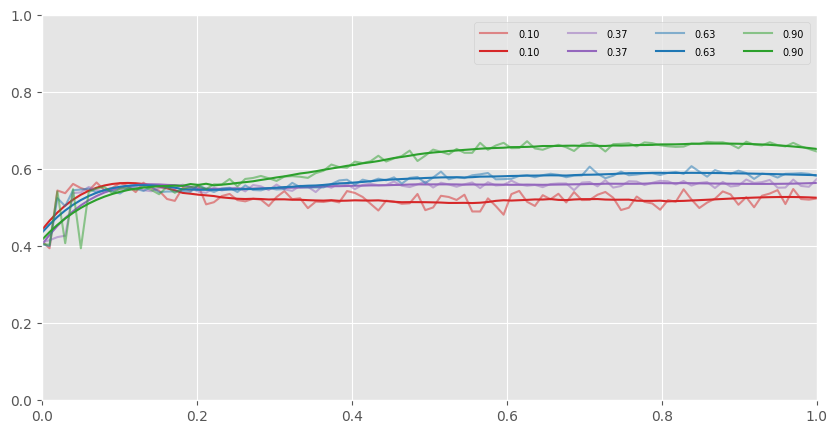

In [943]:
for r in resultados_list:
    resultados = json.load(r)

    mediciones = extraer_mediciones_totales(resultados, 'gini_tk')

    df = pd.DataFrame(mediciones)


    # rename columns
    from string import ascii_lowercase as letters

    colmap = {
        k: letters[i]
        for i, k in enumerate(df.columns)
    }

    inv_colmap = {v:k for k, v in colmap.items()}

    df.rename(columns=colmap, inplace=True)

    colors = {
        'a': 'tab:red',
        'b': 'tab:purple',
        'c': 'tab:blue',
        'd': 'tab:green',
    }

    plt.figure(figsize=(10,5))
    plt.xlim(0,1)
    plt.ylim(0,1)

    #title = plt.title('Gini total por capital. Cuatro cuadrantes. 1.0')
    #title.set_color('black')


    N = 50*50
    for alpha in df.columns:
        plt.plot(df.index, df[alpha], alpha=.5, color=colors[alpha], label=f'{inv_colmap[alpha]:.2f}')
        plt.plot(df.index, smooth_data(df[alpha]), alpha=1, color=colors[alpha], label=f'{inv_colmap[alpha]:.2f}')

    legend = plt.legend(loc='best', ncol=4)
    for t in legend.get_texts():
        t.set_color('black')
        t.set_fontsize(7)

    plt.show()